<div style="float:left;margin:5px 10px 5px 10px" markdown="1">
    <img src="images/auc.png" width="300">
</div>

<div style="float:right;margin-top:10px" markdown="1">
    <h3><i>Text Mining & Collective Intelligence</i></h3>
</div>

<br><br><br><br>

<center><h1>Semantics with Sparse & Dense Vectors</h1>

<br>

<h3>by Gianluca E. Lebani</h3>
<h4>• 17 Oct. 2017 •</h4>

</center>

<br>

>### Today
>
>- [Sparse Vectors](#Sparse-Vectors)
>
>
>- [Calculating Cosine Similarities](#Calculating-Cosine-Similarities)
>
>
>- [Visualizing Similarities](#Visualizing-Similarities)
>
>
>- [Evaluating your Model](#Evaluating-your-Model)
>
>
>- [Working with Dense Vectors](#Working-with-Dense-Vectors)

---

In [1]:
from __future__ import division

import math 

from itertools import chain, permutations, product
from collections import Counter

import nltk
import numpy as np
import scipy
import sklearn

import matplotlib.pyplot as plt

from scipy import cluster
from sklearn import manifold, metrics

plt.rcdefaults()

---

![alt text](images/previously.png)

- from a **pos-tagged and lemmatized** version of the Brown corpus, filtered by removing punctuation marks and "X" (i.e. "OTHER") words...

In [2]:
un2wn_mapping = {"VERB" : "v", "NOUN" : "n", "ADJ" : "a", "ADV" : "r"}

brown_lemmatized = []

for sentence in nltk.corpus.brown.tagged_sents(tagset='universal'):
    lemmatized_sentence = []
    for w, p in sentence:
        if p in [".", "X"]:
            continue
        elif p in un2wn_mapping.keys():
            lemma = nltk.WordNetLemmatizer().lemmatize(w, pos = un2wn_mapping[p])
        else:
            lemma = nltk.WordNetLemmatizer().lemmatize(w)
        lemmatized_sentence.append("-".join([lemma, p]))
        
    brown_lemmatized.append(lemmatized_sentence)

- we've extracted all the **surface co-occurrences** between a noun and another lemma in a ±5 words collocational span...

In [3]:
spansize = 5

cooccs_surface = Counter()

for sentence in brown_lemmatized:
    for i,w in enumerate(sentence):
        if w.split("-")[-1] == "NOUN":
            span_range = range(max(i- spansize, 0), i)  # left side indexes
            span_range.extend(range(i+1, min(i + spansize + 1, len(sentence))))  # add the right side indexes
            for cw in [sentence[idx] for idx in span_range]:
                cooccs_surface[(w, cw)] += 1

print len(cooccs_surface), "target-context pairs"

1277337 target-context pairs


- we chose to ignore all those context words that were:
 
    - highly infrequent (i.e. we apply a minimum frequency threshold of **10**)
    - instances of **closed class** words 
    - semantically "empty" verbs like "be", "have", "do", "would", "will"...

In [4]:
filtered_brown_lemmas_frequencies = Counter()

for k,v in Counter(chain(*brown_lemmatized)).iteritems():
    if v >= 10 and \
    k.split("-")[-1] in ["NOUN", "VERB", "ADJ", "ADV"]\
    and k.split("-")[0] not in ["be", "have", "do", "would", "will", "could"]:
        filtered_brown_lemmas_frequencies[k] = v

print len(filtered_brown_lemmas_frequencies), "context lemmas"

7576 context lemmas


- we chose to ignore all those target nouns that were:
 
    - highly infrequent (i.e. we apply a minimum frequency threshold of **10**)
    - shorter than 3 characters...

In [5]:
selected_brown_noun_frequencies = Counter()

for k,v in Counter([w for w in chain(*brown_lemmatized) if w.split("-")[-1] == "NOUN"]).most_common():
    if len(k) < 8:  # i.e. let's ignore lemmas shorted the 3 characters
        continue
    elif v == 10:
        break
    else:
        selected_brown_noun_frequencies[k] = v

print len(selected_brown_noun_frequencies), "target nouns"

4045 target nouns


In [6]:
filtered_cooccs_surface = Counter()

for k,v in cooccs_surface.iteritems():
    if selected_brown_noun_frequencies.has_key(k[0]) and filtered_brown_lemmas_frequencies.has_key(k[1]):
        filtered_cooccs_surface[k] = v

print len(filtered_cooccs_surface), "selected target-context pairs"

537486 selected target-context pairs


---

<div style="float:left;margin:0 25px 10px 20px">
    <img src="images/your_turn.jpg" width="110">
</div>

#### Your Turn.

How many noun-context pairings never occurr in our corpus? 

In [ ]:
# your code here

---

- we finally **weighted** our raw counts by using the following three association measures:

In [7]:
from __future__ import division 
from math import log

# All functions receive as arguments:
#
#   o_11>> the joint frequency of w1 and w2 >> f(w1, w2)
#   r_1 >> w1 marginals >> f(w1, *)
#   c_1 >> w2 marginals >> f(*, w2)
#   n >> total number of possible coccorrencies >> f(*, *)

# These arguments can be arranged in a contingency table of the form:
#
#          w2    ~w2
#        ------ ------
#    w1 | o_11 | o_12 | = r_1
#        ------ ------
#   ~w1 | o_21 | o_22 | = r_2
#        ------ ------
#        = c_1  = c_2   = n


def ppmi(o_11, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    PMI is also available also in NLTK:
    from nltk.metrics import BigramAssocMeasures
    print BigramAssocMeasures.pmi(8, (15828, 4675), 14307668)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)


def plmi(o_11, r_1, c_1, n):
    """
    Positive Local Mutual Information, useful for leveraging the 
    low-frequency bias of the PPMI
    """
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res


def log_likelihood(o_11, r_1, c_1, n):
    """
    Log Likelihood measure (Dunning, 1993) or "G-squared" measure 

    NOTE that when o_ii is zero log_2(o_ii) is negative infinity and python
    raises a ValueError. Howere,we're summing up o_ii * log_2(o_ii/e_ii)
    and the limit of this factor goes to zero, so that we can simply
    ignore those cells where o_ii is zero
    """
    obs_table = [o_11, r_1 - o_11, c_1 - o_11, n - (c_1 + r_1 - o_11)]  # o_11, o_12, o_21, o_22
    exp_table = [(r_1 * c_1)/ n,
                 (r_1 * (n - c_1))/ n,
                 ((n - r_1) * c_1)/ n,
                 ((n - r_1) * (n - c_1))/ n]  # e_11, e_12, e_21, e_22
    res = 0
    for i, obs in enumerate(obs_table):
        try:
            res += obs * log(obs / exp_table[i])
        except ValueError:
            continue
    res = 2 * res
    return res

In [8]:
ppmis_surface = Counter()

N = sum(cooccs_surface.itervalues())  # note that this is NOT the reduced dictionary

for k,v in filtered_cooccs_surface.iteritems():
    ppmis_surface[k] = ppmi(v, selected_brown_noun_frequencies[k[0]], filtered_brown_lemmas_frequencies[k[1]], N)
    
print ppmis_surface.most_common(20)

[((u'Kong-NOUN', u'Hong-NOUN'), 17.654091187664235), ((u'Hong-NOUN', u'Kong-NOUN'), 17.654091187664235), ((u'Income-NOUN', u'Gross-ADJ'), 17.654091187664235), ((u'Income-NOUN', u'Adjusted-VERB'), 17.376557212135328), ((u'Nam-NOUN', u'Viet-NOUN'), 17.113522806301532), ((u'Viet-NOUN', u'Nam-NOUN'), 17.113522806301532), ((u'Purdew-NOUN', u'Simms-NOUN'), 17.026059965051196), ((u'Simms-NOUN', u'Purdew-NOUN'), 17.026059965051196), ((u'Lao-NOUN', u'Pathet-NOUN'), 17.026059965051196), ((u'lagoon-NOUN', u'aerate-VERB'), 16.91712559349803), ((u'WTV-NOUN', u'antigen-NOUN'), 16.828120587439287), ((u'antigen-NOUN', u'WTV-NOUN'), 16.828120587439287), ((u'Islands-NOUN', u'Guam-NOUN'), 16.818066922775362), ((u'Guam-NOUN', u'Islands-NOUN'), 16.818066922775362), ((u'Iliad-NOUN', u'Odyssey-NOUN'), 16.791594711414174), ((u'Market-NOUN', u'Common-ADJ'), 16.791594711414174), ((u'Tribune-NOUN', u'Herald-NOUN'), 16.76100639158075), ((u'Herald-NOUN', u'Tribune-NOUN'), 16.76100639158075), ((u'Shu-NOUN', u'Lo-NO

In [9]:
plmis_surface = Counter()

N = sum(cooccs_surface.itervalues())  # note that this is NOT the reduced dictionary

for k,v in filtered_cooccs_surface.iteritems():
    plmis_surface[k] = plmi(v, selected_brown_noun_frequencies[k[0]], filtered_brown_lemmas_frequencies[k[1]], N)
    
print plmis_surface.most_common(20)

[((u'States-NOUN', u'United-VERB'), 4787.77840883779), ((u'York-NOUN', u'New-ADJ'), 3621.1147930991538), ((u'year-NOUN', u'ago-ADV'), 1464.8885373164483), ((u'Island-NOUN', u'Rhode-NOUN'), 1258.5533261922783), ((u'Rhode-NOUN', u'Island-NOUN'), 1258.5533261922783), ((u'Mrs.-NOUN', u'Mrs.-NOUN'), 1187.8825846241932), ((u'year-NOUN', u'last-ADJ'), 928.5404042426062), ((u'House-NOUN', u'White-ADJ'), 851.4369612227013), ((u'World-NOUN', u'War-NOUN'), 810.2368093216919), ((u'War-NOUN', u'World-NOUN'), 810.2368093216919), ((u'year-NOUN', u'fiscal-ADJ'), 806.8805607815154), ((u'Corps-NOUN', u'Peace-NOUN'), 764.6181753280484), ((u'Peace-NOUN', u'Corps-NOUN'), 764.6181753280484), ((u'Angeles-NOUN', u'Los-NOUN'), 725.7315808235118), ((u'Los-NOUN', u'Angeles-NOUN'), 725.7315808235118), ((u'time-NOUN', u'same-ADJ'), 716.6845161499051), ((u'school-NOUN', u'high-ADJ'), 684.1104956382288), ((u'place-NOUN', u'take-VERB'), 682.1673150786678), ((u'Nations-NOUN', u'United-VERB'), 602.2264808844225), ((u'M

In [10]:
lls_surface = Counter()

N = sum(cooccs_surface.itervalues())  # note that this is NOT the reduced dictionary

for k,v in filtered_cooccs_surface.iteritems():
    lls_surface[k] = log_likelihood(v, selected_brown_noun_frequencies[k[0]], filtered_brown_lemmas_frequencies[k[1]], N)
    
print lls_surface.most_common(20)

[((u'States-NOUN', u'United-VERB'), 6953.964479037217), ((u'York-NOUN', u'New-ADJ'), 5218.669840636507), ((u'year-NOUN', u'ago-ADV'), 1864.8375330848553), ((u'Island-NOUN', u'Rhode-NOUN'), 1771.6494950804188), ((u'Rhode-NOUN', u'Island-NOUN'), 1771.6494950804188), ((u'Mrs.-NOUN', u'Mrs.-NOUN'), 1465.3982476383976), ((u'House-NOUN', u'White-ADJ'), 1143.7883279065052), ((u'year-NOUN', u'last-ADJ'), 1092.4697574612487), ((u'Angeles-NOUN', u'Los-NOUN'), 1079.7123743764696), ((u'Los-NOUN', u'Angeles-NOUN'), 1079.7123743764696), ((u'World-NOUN', u'War-NOUN'), 1075.82017865477), ((u'War-NOUN', u'World-NOUN'), 1075.8201786547697), ((u'Corps-NOUN', u'Peace-NOUN'), 1063.633984978412), ((u'Peace-NOUN', u'Corps-NOUN'), 1063.633984978412), ((u'year-NOUN', u'fiscal-ADJ'), 1038.9416903080191), ((u'Motors-NOUN', u'General-NOUN'), 822.8840108112654), ((u'General-NOUN', u'Motors-NOUN'), 822.8840108112654), ((u'time-NOUN', u'same-ADJ'), 821.8472343257614), ((u'San-NOUN', u'Francisco-NOUN'), 821.647491485

## Sparse Vectors

![alt text](images/3dvectors.png)

Let's create our vectors by populating a DENSE matrix for each of oue type of weighted co-occurrences:

In [11]:
# lemma 2 rows/column index mapppings
sorted_vectors = sorted(selected_brown_noun_frequencies)
vectors_indices = dict((v,i) for i,v in enumerate(sorted_vectors))
contexts_indices = dict((v,i) for i,v in enumerate(sorted(filtered_brown_lemmas_frequencies)))

In [12]:
# initialize the PPMI Weighted dense matrix
ppmiMat = np.zeros((len(vectors_indices), len(contexts_indices)))

# populate the matrix
for pair, weight in ppmis_surface.iteritems():
    ppmiMat[vectors_indices[pair[0]]][contexts_indices[pair[1]]] = weight

In [13]:
print ppmiMat

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [14]:
# initialize the PLMI Weighted dense matrix
plmiMat = np.zeros((len(vectors_indices), len(contexts_indices)))

# populate the matrix
for pair, weight in plmis_surface.iteritems():
    plmiMat[vectors_indices[pair[0]]][contexts_indices[pair[1]]] = weight

In [ ]:
# initialize the LL Weighted dense matrix
llMat = np.zeros((len(vectors_indices), len(contexts_indices)))

# populate the matrix
for pair, weight in lls_surface.iteritems():
    llMat[vectors_indices[pair[0]]][contexts_indices[pair[1]]] = weight

---

## Calculating Cosine Similarities

![alt text](images/vectors-similarity.png)

The diverse similarity measures we've mentioned in class can be calculated by using the **distance** measures available in virtually all the above cited toolkits, or can be easily implemented. 

For instance, the **cosine similarity** between the two Numpy arrays `v_1` and `v_2` can be calculated by using one of the following functions:

In [ ]:
v_1 = np.array([-0.012813841, -0.024518383, -0.002765056,  0.079496744,  0.063928973, 0.476156960, 0.122111977, 0.322930189, 
                0.400701256,  0.454048860, 0.525526219])

v_2 = np.array([0.64175768,  0.54625694,  0.40728261,  0.24819750,  0.09406221, 0.16681692, -0.04211932, -0.07130129, 
                -0.08182200, -0.08266852,  -0.07215885])

In [ ]:
def scipy_cosine(v1, v2):
    return 1 - scipy.spatial.distance.cosine(v1,v2)

def nltk_cosine(v1, v2):
    return 1 - nltk.cluster.cosine_distance(v1,v2)

def numpy_cosine(v1, v2):
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / ( mag_v1 * mag_v2)

In [ ]:
%timeit scipy_cosine(v_1, v_2)

In [ ]:
%timeit nltk_cosine(v_1, v_2)

In [ ]:
%timeit numpy_cosine(v_1, v_2)

If (for some reason) you're working on lists, maybe the best solution is to rely on the `math` library.

In [ ]:
def math_cosine(l1, l2):
    d = sum(p*q for p,q in zip(l1, l2))
    mag_l1 = math.sqrt(sum([n**2 for n in l1]))
    mag_l2 = math.sqrt(sum([n**2 for n in l2]))
    return d/( mag_l1 * mag_l2)

In [ ]:
%timeit math_cosine(v_1.tolist(), v_2.tolist())

However, the calculation of the similarity is (together with the extraction of the co-occurrences) the **main bottleneck** of these models, and the above mentioned solutions become **impractical** when comparing all the vectors in a reasonably sized model.

If you want to calculate the similarity on the **whole matrix** at once, a viable solution is to use the methods available in the `sklearn.metrics.pairwise` module, among which the `cosine_similarity` one

In [ ]:
ppmiSimMat = sklearn.metrics.pairwise.cosine_similarity(ppmiMat)
plmiSimMat = sklearn.metrics.pairwise.cosine_similarity(plmiMat)
llSimMat = sklearn.metrics.pairwise.cosine_similarity(llMat)

#### Let's print the 20 most similar nouns to "year" according to each of our spaces

In [ ]:
target_idx = vectors_indices["year-NOUN"]

In [ ]:
print "according to the ppmi space:\n"

for idx in ppmiSimMat[target_idx,].argsort()[::-1][1:21]:
    print sorted_vectors[idx], ppmiSimMat[target_idx, idx]

In [ ]:
print "according to the plmi space:\n"

for idx in plmiSimMat[target_idx,].argsort()[::-1][1:21]:
    print sorted_vectors[idx], plmiSimMat[target_idx, idx]

In [ ]:
print "according to the log-likelihood space:\n"

for idx in llSimMat[target_idx,].argsort()[::-1][1:21]:
    print sorted_vectors[idx], llSimMat[target_idx, idx]

---

<div style="float:left;margin:0 25px 10px 20px">
    <img src="images/your_turn.jpg" width="110">
</div>

#### Your Turn.


Choose three (frequent) nouns and print their top-similar nouns according to each one of the above implemented association measures

In [ ]:
# your code here

---

## Visualizing Similarities

Sometimes it is convenient to look at the distances between your word in order to have an idea of what's going on with your data. Unfortunately, human being do not cope well with more than 3 dimensions (the novel [Flatland: A Romance of Many Dimensions](https://en.wikipedia.org/wiki/Flatland) may be an insightful reading on this topic). 

### Dimensionality Reduction

A usual solution is to reduce the dimensionality of your dataset to **2 or 3 dimensions** trying to preserve the pairwise distances as much as possible. Among the several **non-linear dimensionality reduction techniques** to date available (a quick review is available In the [scikit-learn documentation](http://scikit-learn.org/stable/modules/manifold.html)), the **MULTIDIMENSIONAL SCALING** is widely used to display the information contained in a distance matrix. 

Let's try to use MDS to plot the distance between an (arbitrarily chosen) subset of our nouns:

In [ ]:
lemmas2plot = selected_brown_noun_frequencies.most_common()[200:225]
lemmas2plot_idxs = [vectors_indices[lem[0]] for lem in lemmas2plot]

In [ ]:
measure2mat = {"ppmi": ppmiMat, "plmi": plmiMat, "loglikelihood": llMat}

labels = [p[0].split("-")[0] for p in lemmas2plot]

for i, (m, mat) in enumerate(measure2mat.items()):
    # we need a DISTANCE matrix
    distMat = sklearn.metrics.pairwise.pairwise_distances(mat[lemmas2plot_idxs,:], metric="cosine")
    
    # let's reduce the dimensionality
    mds = sklearn.manifold.MDS(n_components = 2, max_iter = 300, eps = 1e-9, 
                               random_state = np.random.RandomState(seed = 6), 
                               dissimilarity = "precomputed")

    coords = mds.fit(distMat).embedding_
    
    # let's plot the distances
    plt.scatter(coords[:, 0], coords[:, 1], marker = '.', c = 'r')
    
    
    
    for label, x, y in zip(labels, coords[:, 0], coords[:, 1]):
        plt.annotate(label, xy = (x,y), horizontalalignment = 'center', verticalalignment='bottom')

    plt.title("MDS on the " + m +"-based space")

    plt.show()
    

### Clustering

Another viable option is to perform use the pairwise similarities in order to organize our words into groups (i.e. to performs **clustering**). The general idea is to organize clusters so as to maximize the within-group similiarities and the between-group differences. There are many clustering algorithms and techniques, all of them with their pros and cons. 

**Hierachical clustering** techniques do not try to produce a single clustering, but try to produce a hierarchy of groups. As such, they are quite useful in exploratory analysis. In this class, the **Ward** algorithm is an example of **agglomerative** clustering:  each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy. In the Ward's method, the distance between two clusters is the change in the sum of squared distances when they are merged.

We can use the `scipy.cluster.hierarchy.ward()` function to create our hierarchical clustering and the  `scipy.cluster.hierarchy.dendrogram()` function to visualize it (i.e. to create a dendrogram).

In [ ]:
measure2mat = {"ppmi": ppmiMat, "plmi": plmiMat, "loglikelihood": llMat}

labels = [p[0].split("-")[0] for p in lemmas2plot]

for i, (m, mat) in enumerate(measure2mat.items()):
    
    # let's built a DISTANCE matrix
    distMat = sklearn.metrics.pairwise.pairwise_distances(mat[lemmas2plot_idxs,:], metric="cosine")
    
    # as we'll rely the scikit learn function to perform clustering, it is safer to convert our redundant distance matrix 
    # into a condensed distance matrix (i.e. into a flat array containing the upper triangular of the distance matrix)
    condensed_distMat = scipy.spatial.distance.squareform(distMat)
    
    # we could alternatively have used scipy.spatial.distance.pdist() to obtain the distance matric in this format
    # scipyPdist = scipy.spatial.distance.pdist(mat[lemmas2plot_idxs,:], "cosine")
    
    # let's perform the hierarchical clustering
    linkage_matrix = scipy.cluster.hierarchy.ward(condensed_distMat)
    
    # let's create the dendrogram (i.e. let's visualize the structure of the groups)
    scipy.cluster.hierarchy.dendrogram(linkage_matrix, orientation="right", labels=labels)
    
    plt.xlabel ("distance (not cosines, but those used by the Ward's method)")

    plt.title("MDS on the " + m +"-based space")
    
    plt.tight_layout()

    plt.show()

## Evaluating your Model

VSMs can be evaluated on **Semantic Similarity Tasks**, in which they are required to simulate the pairwise similarity judgments collected from speakers.

In what follows we evaluate our models against the [WordSim-353 dataset](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/):


- 353 noun pairs rated on a 0-10 scale 


- measure: spearman's correlation between algorithm and human word similarity ratings

In [23]:
dimensions = 300

In [24]:
# note that the default SVD solver is the randomized algorithm proposed by Halko (2009), but we select the ARPACK wrapper 
# in SciPy (scipy.sparse.linalg.svds) because is more efficient (but slower)
ppmiMat_tr300 = sklearn.decomposition.TruncatedSVD(n_components = dimensions, algorithm = "arpack").fit_transform(ppmiMat)

ppmiSVD300SimMat = sklearn.metrics.pairwise.cosine_similarity(ppmiMat_tr300)

In [28]:
len(ppmiSVD300SimMat)

4045

In [20]:
# let's select the pairs of nouns for which we have aenough disitrbutional information

wordSim353 = dict()

with open("data/wordSim353.csv","rb") as infile:
    infile.next()
    for line in infile:
        raw_w1, raw_w2, rating = unicode(line).strip().split(",")
        w1 = raw_w1+"-NOUN"
        w2 = raw_w2+"-NOUN"
        if all([vectors_indices.has_key(w) for w in [w1,w2]]):
            wordSim353[(w1, w2)] = float(rating)

- Note that due to the size of our corpus we've lost 1/3 of the dataset

In [21]:
print len(wordSim353) 

214


In [29]:
measure2mat = {"positivePMI": ppmiSimMat}

rhos = []
measures = []

for m, mat in measure2mat.items():
    print m+"-based space vs. wordSim353 -> spearman's rho:\t", 
    
    wordSim_ratings = []
    vsm_sims = []
    for (w1, w2), r in wordSim353.iteritems():
        w1idx = vectors_indices[w1]
        w2idx = vectors_indices[w2]
        
        wordSim_ratings.append(r)
        vsm_sims.append(mat[w1idx, w2idx])
        
    rho, pval = scipy.stats.spearmanr(wordSim_ratings, vsm_sims)
    
    print rho
    rhos.append(rho)
    measures.append(m)

NameError: name 'ppmiSimMat' is not defined

In [ ]:
plt.bar(range(0, len(rhos)), rhos)
plt.xticks(range(0, len(rhos)), measures, size='small')
plt.show()

---

## Working with Dense Vectors

Up to this moment, we've worked with **long** and **sparse** vectors:


- the proportion of zeros in our ppmi weighted matrix is:

In [ ]:
np.count_nonzero(ppmiMat) / ppmiMat.size

- the length of our vectors:

In [ ]:
ppmiMat.shape[1]

**Denser** representations have a number of **advantages**, among which:

- their computationally easier to manipulate (e.g. to create  or to use as ML features)


- they tend to be less noisy


- they exploit latent meaning dimensions (e.g. they may tend to merge together correlated contexts like *car* and *automobile*)

> **Dimensionality Reduction**: the process of reducing the number of features (i.e. contextual markers) by mapping data points (i.e. the vectors describing the target words) into a **low-dimensional subspace**

### Dimensionality Reduction via Singular Value Decomposition

- *The SVD is the Swiss Army knife of matrix decompositions* (O'Leary, 2006)


- SVD is a method for finding, for a given dataset, the **dimensions on which the data varies the most** (Jurafsky & Martin, 2018)

**Intuitive Idea**: rotate the axes of the dataset into a new space, so that the order of the dimension is related to the quantity of captured variance

- first dimension capture the most variance, then the second captures most of the variance unexplained by the first dimension and so on...


- many related methods: PCA, Factor Analysis, **SVD**

#### Matrix Factorization

SVD **factorizes** a (non-symmetric, non-square) $w \times c$ matrix $M$ into the **product of three matrices**: $U \cdot\Sigma \cdot V^T$, where:


- $U$: the rows correspond to the rows of M (i.e. our target words) and the columns represent the dimensions of the **latent space**
    - dimensions are orthogonal
    - dimensions are sorted according to the amount of variance they explain
    - e.g. the word frequency distribution for any latent topic
    
    
- $\Sigma$: a diagonal $m \times m$ matrix (where $m$ is the rank of our matrix $M$) of singular values in decreasing order
    - intuitively, the **square** each singular value $\sigma$ express the importance of each dimension
    - e.g. the prior frequency of each latent topic

    
- $V^T$: the columns correspond the columns of M and the rows correspond to the singular values 
    - e.g. the contribution of each latent topic to each context

$$\mathop{\begin{bmatrix}
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & M & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
\end{bmatrix}}_{\textstyle w \times c} \ = \
\mathop{\begin{bmatrix}
 & & & & \\
 & & & & \\
 & & & & \\
 & & & & \\
 & & U & & \\
 & & & & \\
 & & & & \\
 & & & & \\
 & & & & \\
\end{bmatrix}}_{\textstyle w \times m}\ 
\mathop{\begin{bmatrix}
\sigma_1 & 0 & 0 & \cdots & 0 \\
0 & \sigma_2 & 0 & \cdots & 0 \\
0 & 0 & \sigma_3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \sigma_m \\
\end{bmatrix}}_{\textstyle m \times m}\ 
\mathop{\begin{bmatrix}
 & & & & & &\\
 & & & & & &\\
 & & & V^T & & &\\
 & & & & & &\\
 & & & & & &\\
\end{bmatrix}}_{\textstyle m \times c}$$

#### Truncation

If we use the **first $d$ singular values**, we obtain a **truncated matrix** $\tilde{M}_d$ that is **a least-squares approximation** to the original $M$


- dimensions $d < x < m$ are descarded
    - by removing the dimensions that encode the least variance, we **remove noise**


- generally $50 < d < 1000$ (with a soft spot around 300)


- some authors (Lapesa & Evert, 2014) suggest that for some task it may be useful to get rid of the very first dimensions as well

$$\mathop{\begin{bmatrix}
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & \tilde{M}_d & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
 & & & & & &\\
\end{bmatrix}}_{\textstyle w \times c} \ = \
\mathop{\begin{bmatrix}
 & & \\
 & & \\
 & & \\
 & & \\
 & U_d &\\
 & & \\
 & & \\
 & & \\
 & & \\
\end{bmatrix}}_{\textstyle w \times d}\ 
\mathop{\begin{bmatrix}
 & &\\
 & \Sigma_d & \\
 & & \\
\end{bmatrix}}_{\textstyle d \times d}\
\mathop{\begin{bmatrix}
 & & & & & &\\
 & & & V^T_d & & &\\
 & & & & & &\\
\end{bmatrix}}_{\textstyle d \times c}$$

#### Embedding

We can take advantage of the fact that **dot-products between** the rows of $W = U_d \cdot \Sigma_d$ are equal to those of the rows of $\tilde{M}_d = U_d \cdot \Sigma_d\cdot V^T_d$, so that we can **ignore $V^T_d$** and take the rows of $W$ as our word representations.

Recently, it has been showed (but not explained) that an additional parameter $p$ should be added to control the eigenvalue matrix $\Sigma$, so that we will take as **word representations** the rows of the $W'$ matrix, defined as:

$$W' = U_d \cdot \Sigma_d^p$$

- note that for some tasks, it has been suggested that ignoring $\Sigma$ alltogether (i.e. setting $p = 0$) may lead to an increase in performance


- some authors (e.g. Jurafsky & Martin, 2018) use this setting as the default, but it is wiser to spend some time in tuning this hyperparameters rather than ignoring it altogether

#### With Python

METHOD 1: **using Scikit-learn**


- you cannot set $p$ (it's always $p = 1$)


- you have to know how many dimensions you want in advance


- you cannot descard the first dimensions, if you want to

In [16]:
dimensions = 300

In [17]:
# note that the default SVD solver is the randomized algorithm proposed by Halko (2009), but we select the ARPACK wrapper 
# in SciPy (scipy.sparse.linalg.svds) because is more efficient (but slower)
ppmiMat_tr300 = sklearn.decomposition.TruncatedSVD(n_components = dimensions, algorithm = "arpack").fit_transform(ppmiMat)

ppmiSVD300SimMat = sklearn.metrics.pairwise.cosine_similarity(ppmiMat_tr300)

In [27]:
len(ppmiSVD300SimMat)

4045

In [33]:
measure2mat = {"positivePMI": ppmiSimMat, "positiveLMI": plmiSimMat}
rhos = []
measures = []

for m, mat in measure2mat.items():
    print m+"-based space vs. wordSim353 -> spearman's rho:\t", 
    
    wordSim_ratings = []
    vsm_sims = []
    for (w1, w2), r in wordSim353.iteritems():
        w1idx = vectors_indices[w1]
        w2idx = vectors_indices[w2]
        
        wordSim_ratings.append(r)
        vsm_sims.append(mat[w1idx, w2idx])
        
    rho, pval = scipy.stats.spearmanr(wordSim_ratings, vsm_sims)
    
    print rho
    rhos.append(rho)
    measures.append(m)

NameError: name 'ppmiSimMat' is not defined

In [30]:
print measure2mat

{'ppmi_SVD300': array([[ 1.        ,  0.19326777,  0.3804721 , ..., -0.03895291,
         0.08836525, -0.03243734],
       [ 0.19326777,  1.        ,  0.06937117, ...,  0.06334529,
         0.10360852,  0.04470543],
       [ 0.3804721 ,  0.06937117,  1.        , ...,  0.05207912,
         0.10541757, -0.04517519],
       ..., 
       [-0.03895291,  0.06334529,  0.05207912, ...,  1.        ,
         0.30966063,  0.20650068],
       [ 0.08836525,  0.10360852,  0.10541757, ...,  0.30966063,
         1.        ,  0.06631481],
       [-0.03243734,  0.04470543, -0.04517519, ...,  0.20650068,
         0.06631481,  1.        ]])}


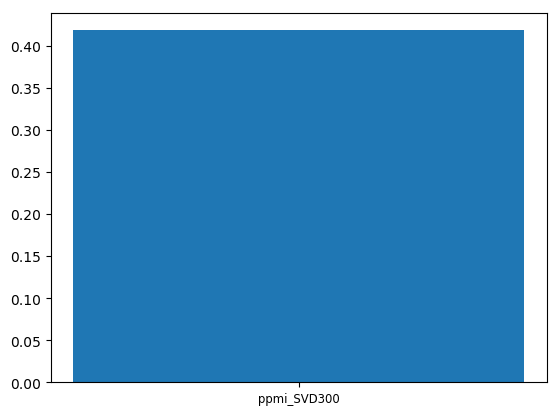

In [31]:
plt.bar(range(0, len(rhos)), rhos)
plt.xticks(range(0, len(rhos)), measures, size='small')
plt.show()

Well, it worked! But let's see what happens if we play a bit with our hyperparamaters...

METHOD 2: **using Scipy modules**

We can (roughly) re-implement what we've done with scikit-learn as follows:

In [ ]:
from scipy import linalg, dot

# let's decompose our matrix (we can safely ignore Vt)
U, s, Vt = linalg.svd(ppmiMat)  

# SVD suffers from a problem called "sign indeterminancy", so that the sign of the components (i.e. U and Vt) depends
# on the initial state and on the algorithm. As a consequence, if U (and V) are mostly negative, their sign should be inverted
if not U[U>0].size > (U.size / 2):
    U = -U
    Vt = -Vt

In [ ]:
# let's filter out all dimensions but the first 300
W = U[:, 0 : dimensions]
sigma = s[:dimensions]  # note that for efficiency reasons sigma is an array, not a matrix
C = Vt[0 : dimensions, :]

ppmiMat_tr300_alt = dot(W, linalg.diagsvd(sigma, dimensions, len(C)))

EXPLAINED VARIANCE: the **Scree Plot**

A graph plotting variances against singular values is called a scree plot

We can choose how many dimensions to retain by checking the portion of variance each dimension is able to explain:

- given that the square of each singular value is proportional to the variance explained by each singular vector, we compute the relative contribution of each singular value by dividing the square of the singular value $k$ by the sum of the squares of all the singular values

In [ ]:
rel_variance = ( s**2 / sum(s**2) ) * 100
y_values =  rel_variance
x_values = np.arange(len(y_values))

plt.plot(x_values, y_values, linestyle = '-')

plt.xlabel("Singular Values", labelpad = 20)
plt.ylabel("Relative Variance (%)", labelpad = 10)

plt.show()

Let's focus on the first singular values...

In [ ]:
y_values =  rel_variance[:500] 
x_values = np.arange(len(y_values))

plt.plot(x_values, y_values, linestyle = '-')

plt.xlabel("Singular Values", labelpad = 20)
plt.ylabel("Relative Variance (%)", labelpad = 10)

plt.show()

In [ ]:
dimensions = 50

W = U[:, 0 : dimensions]
sigma = s[:dimensions]
C = Vt[0 : dimensions, :]

ppmiMat_tr50 = dot(W, linalg.diagsvd(sigma, dimensions, len(C)))

In [ ]:
measure2mat = {"ppmi_SVD50": ppmiMat_tr50}

for m, mat in measure2mat.items():
    print m+"-based space vs. wordSim353 -> spearman's rho:\t", 
    
    sim = sklearn.metrics.pairwise.cosine_similarity(mat)
    
    wordSim_ratings = []
    vsm_sims = []
    for (w1, w2), r in wordSim353.iteritems():
        w1idx = vectors_indices[w1]
        w2idx = vectors_indices[w2]
        
        wordSim_ratings.append(r)
        vsm_sims.append(sim[w1idx, w2idx])
        
    rho, pval = scipy.stats.spearmanr(wordSim_ratings, vsm_sims)
    
    print rho
    rhos.append(rho)
    measures.append(m)

In [ ]:
plt.bar(range(0, len(rhos)), rhos)
plt.xticks(range(0, len(rhos)), measures, size='small', rotation='vertical')
plt.show()

---

<div style="float:left;margin:0 25px 10px 20px">
    <img src="images/your_turn.jpg" width="110">
</div>

#### Your Turn.

Try to remove the first dimensions as well. What happens?

In [ ]:
# your code here

---

WEIGHTING $\Sigma$

Some authors suggested to downgrade the influence of $\Sigma$ on the final word representation by applying a weight $0 < p < 1$

In [ ]:
dimensions = 50

In [ ]:
# let's use only U, i.e. if p == 0

p = 0.

W = U[:, 0 : dimensions]
sigma = s[:dimensions]
C = Vt[0 : dimensions, :] 

ppmiMat_tr50_p0 = dot(W, linalg.diagsvd(sigma ** p , dimensions, len(C)))

In [ ]:
# this is equivalent to using only W
np.allclose(ppmiMat_tr50_p0, W)

In [ ]:
p = 0.5

W = U[:, 0 : dimensions]
sigma = s[:dimensions]
C = Vt[0 : dimensions, :] 

ppmiMat_tr50_p5 = dot(W, linalg.diagsvd(sigma ** p, dimensions, len(C)))

In [ ]:
measure2mat = {"ppmi_SVD50_p.0": ppmiMat_tr50_p0,
              "ppmi_SVD50_p.5": ppmiMat_tr50_p5,}

for m, mat in measure2mat.items():
    print m+"-based space vs. wordSim353 -> spearman's rho:\t", 
    
    sim = sklearn.metrics.pairwise.cosine_similarity(mat)
    
    wordSim_ratings = []
    vsm_sims = []
    for (w1, w2), r in wordSim353.iteritems():
        w1idx = vectors_indices[w1]
        w2idx = vectors_indices[w2]
        
        wordSim_ratings.append(r)
        vsm_sims.append(sim[w1idx, w2idx])
        
    rho, pval = scipy.stats.spearmanr(wordSim_ratings, vsm_sims)
    
    print rho
    rhos.append(rho)
    measures.append(m)

In [ ]:
plt.bar(range(0, len(rhos)), rhos)
plt.xticks(range(0, len(rhos)), measures, size='small', rotation='vertical')
plt.show()

---

### Exercise 1.

Apply SVD to the PLMI Weighted dense matrix `plmiMat` and evaluate the model

In [ ]:
# your code here

### Exercise 2.

Create and evaluate a plmi-weighted DSM based on the co-occurrences in a ±10 words collocational span

In [ ]:
# your code here

### Exercise 3.

create a plmi-based space build from the following **sentence splitted and tokenized** version of the Brown corpus obtained by:

- filtering out the tokens composed solely by punctuation marks and

- lowering all the tokens

In [ ]:
import string

brown_words_raw = []

for sentence in nltk.corpus.brown.sents():
    brown_words_raw.append([w.lower() for w in sentence if not set(w).issubset(string.punctuation)])

In [ ]:
# your code here

---

ignore what follows

In [ ]:
# Export this notebook as a HTML file
# !jupyter nbconvert TMCI-2017-w7a --output html_converted_notebooks/TMCI-2017-w7a